# Unsupervised Network Intrusion Detection System (NIDS)
## Modeling Notebook - NSL-KDD Dataset

---

### Table of Contents

| Section | Title | Description |
|---------|-------|-------------|
| 0 | **Notebook Structure** | This table of contents |
| 1 | **Data Load & Sanity Check** | Load datasets, verify shapes, check distributions |
| 2 | **Binary Label & Dataset Splits** | Create is_attack, define train/test sets |
| 3 | **Feature List & Service Grouping** | Identify columns, group rare services |
| 4 | **Preprocessing Contract** | Document preprocessing decisions |
| 5 | **Preprocessing Implementation** | Fit & transform features |
| 6 | **Dimensionality Reduction** | Optional PCA for model speed |
| 7 | **Evaluation Protocol** | Define models, metrics, thresholds |
| 8 | **Validation Set** | Create val set for tuning |
| 9 | **Isolation Forest** | Train & Evaluate Model 1 |
| 10 | **Local Outlier Factor** | Train & Evaluate Model 2 |
| 11 | **Dense Autoencoder** | Train & Evaluate Model 3 |
| 12 | **Model Comparison** | Side-by-side metrics & plots |
| 13 | **Threshold Selection** | select decision boundary (1% FPR) |
| 14 | **Explainability** | Analyze anomalies |
| 15 | **Final Selection** | Choose best model & save |

---

**Key Principle:** Train on **normal traffic only** (semi-supervised/unsupervised protocol). Test labels used for evaluation only.

---
## Environment Setup

In [3]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import json
import time
import os
from pathlib import Path

# Sklearn
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import (
    roc_auc_score, roc_curve,
    precision_recall_curve, auc,
    precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from sklearn.model_selection import train_test_split

# Utilities
import joblib
from tqdm import tqdm

# Settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)
plt.style.use('seaborn-v0_8-whitegrid')

# ROBUST PATH HANDLING
# --------------------
curr_dir = Path.cwd()
if curr_dir.name == 'notebooks':
    # Running in notebooks/ directory
    PROJECT_ROOT = curr_dir.parent
else:
    # Assuming running in project root
    PROJECT_ROOT = curr_dir

DATA_RAW = PROJECT_ROOT / '/content/sample_data'
ARTIFACTS = PROJECT_ROOT / 'artifacts'
FIGURES = PROJECT_ROOT / 'figures'

# Ensure directories exist
ARTIFACTS.mkdir(parents=True, exist_ok=True)
FIGURES.mkdir(parents=True, exist_ok=True)

print(f"Pandas: {pd.__version__}")
print(f"Project Root: {PROJECT_ROOT}")
print(f"Artifacts Dir: {ARTIFACTS}")
print("Environment ready!")

Pandas: 2.2.2
Project Root: /content
Artifacts Dir: /content/artifacts
Environment ready!


---
# 1. Data Load & Quick Sanity Check

Load the NSL-KDD training and test datasets.

In [4]:
# Column names for NSL-KDD (no header in raw files)
COLUMN_NAMES = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
    'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in',
    'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
    'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login',
    'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate',
    'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
    'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
    'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate',
    'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label', 'difficulty_level'
]

# Load datasets
train_df = pd.read_csv(DATA_RAW / 'KDDTrain+.txt', header=None, names=COLUMN_NAMES)
test_df = pd.read_csv(DATA_RAW / 'KDDTest+.txt', header=None, names=COLUMN_NAMES)

print("Datasets loaded successfully!")

Datasets loaded successfully!


### 1.1 Dataset Shapes

Verify the dimensions of our training and test sets.

In [7]:
print("=" * 50)
print("DATASET DIMENSIONS")
print("=" * 50)
print(f"Training set: {train_df.shape[0]:,} rows × {train_df.shape[1]} columns")
print(f"Test set:     {test_df.shape[0]:,} rows × {test_df.shape[1]} columns")
print(f"Total samples: {train_df.shape[0] + test_df.shape[0]:,}")

DATASET DIMENSIONS
Training set: 125,973 rows × 43 columns
Test set:     22,544 rows × 43 columns
Total samples: 148,517


**Observations:**
- Training: ~125,973 rows × 43 columns
- Test: ~22,544 rows × 43 columns
- Both datasets have the same number of columns, as expected.

### 1.2 Sample Data

In [8]:
print("First 8 rows of Training Data:")
train_df.head(8)

First 8 rows of Training Data:


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,difficulty_level
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21
5,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,121,19,0.0,0.0,1.0,1.0,0.16,0.06,0.00,255,19,0.07,0.07,0.00,0.00,0.00,0.00,1.00,1.00,neptune,21
6,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,166,9,1.0,1.0,0.0,0.0,0.05,0.06,0.00,255,9,0.04,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,21
7,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,117,16,1.0,1.0,0.0,0.0,0.14,0.06,0.00,255,15,0.06,0.07,0.00,0.00,1.00,1.00,0.00,0.00,neptune,21


### 1.3 Label Distribution

In [11]:
print("=" * 50)
print("LABEL DISTRIBUTION")
print("=" * 50)

print("--- Training Set ---")
train_label_dist = train_df['label'].value_counts()
print(f"Total unique labels: {len(train_label_dist)}")
print(f"Top 10 labels:")
print(train_label_dist.head(10))
print(f"Normal vs Attack:")
normal_train = (train_df['label'] == 'normal').sum()
attack_train = (train_df['label'] != 'normal').sum()
print(f"  Normal: {normal_train:,} ({100*normal_train/len(train_df):.1f}%)")
print(f"  Attack: {attack_train:,} ({100*attack_train/len(train_df):.1f}%)")

print("--- Test Set ---")
test_label_dist = test_df['label'].value_counts()
print(f"Total unique labels: {len(test_label_dist)}")
print(f"Top 10 labels:")
print(test_label_dist.head(10))
print(f"Normal vs Attack:")
normal_test = (test_df['label'] == 'normal').sum()
attack_test = (test_df['label'] != 'normal').sum()
print(f"  Normal: {normal_test:,} ({100*normal_test/len(test_df):.1f}%)")
print(f"  Attack: {attack_test:,} ({100*attack_test/len(test_df):.1f}%)")

LABEL DISTRIBUTION
--- Training Set ---
Total unique labels: 23
Top 10 labels:
label
normal         67343
neptune        41214
satan           3633
ipsweep         3599
portsweep       2931
smurf           2646
nmap            1493
back             956
teardrop         892
warezclient      890
Name: count, dtype: int64
Normal vs Attack:
  Normal: 67,343 (53.5%)
  Attack: 58,630 (46.5%)
--- Test Set ---
Total unique labels: 38
Top 10 labels:
label
normal          9711
neptune         4657
guess_passwd    1231
mscan            996
warezmaster      944
apache2          737
satan            735
processtable     685
smurf            665
back             359
Name: count, dtype: int64
Normal vs Attack:
  Normal: 9,711 (43.1%)
  Attack: 12,833 (56.9%)


### 1.4 Categorical Feature Counts

In [13]:
print("=" * 50)
print("CATEGORICAL FEATURE UNIQUE VALUES")
print("=" * 50)

categorical_cols = ['protocol_type', 'service', 'flag']

for col in categorical_cols:
    train_unique = train_df[col].nunique()
    test_unique = test_df[col].nunique()
    print(f"{col}:")
    print(f"  Train unique: {train_unique}")
    print(f"  Test unique:  {test_unique}")

    # Check for values in test not in train
    train_vals = set(train_df[col].unique())
    test_vals = set(test_df[col].unique())
    new_in_test = test_vals - train_vals
    if new_in_test:
        print(f"  ⚠️ New values in test: {new_in_test}")

CATEGORICAL FEATURE UNIQUE VALUES
protocol_type:
  Train unique: 3
  Test unique:  3
service:
  Train unique: 70
  Test unique:  64
flag:
  Train unique: 11
  Test unique:  11


### 1.5 Missing Values & Irregularities Check

In [15]:
print("=" * 50)
print("DATA QUALITY CHECK")
print("=" * 50)

# Missing values
train_missing = train_df.isnull().sum().sum()
test_missing = test_df.isnull().sum().sum()
print(f"Missing values:")
print(f"  Training: {train_missing}")
print(f"  Test: {test_missing}")

# Check for unexpected label names
all_labels = set(train_df['label'].unique()) | set(test_df['label'].unique())
print(f"All unique labels across datasets: {len(all_labels)}")

# Check difficulty_level column
print(f"Difficulty level range (train): {train_df['difficulty_level'].min()} - {train_df['difficulty_level'].max()}")
print(f"Difficulty level range (test):  {test_df['difficulty_level'].min()} - {test_df['difficulty_level'].max()}")

DATA QUALITY CHECK
Missing values:
  Training: 0
  Test: 0
All unique labels across datasets: 40
Difficulty level range (train): 0 - 21
Difficulty level range (test):  0 - 21


### 📝 Data Load Notes

**Observations from initial data exploration:**

1. **No missing values** detected in either dataset ✅
2. **Training set:** ~125,973 samples with ~53% normal, ~47% attack
3. **Test set:** ~22,544 samples with different attack distribution
4. **Categorical features:**
   - `protocol_type`: 3 values (tcp, udp, icmp)
   - `service`: ~70 unique services (high cardinality)
   - `flag`: 11 values
5. **Potential new services in test set** that don't appear in training - will need to handle with "other" grouping
6. **`difficulty_level`** column present - will drop this as it's metadata, not a feature

---
# 2. Create Binary Label & Define Datasets

We create a binary classification target and split data according to the **semi-supervised protocol**.

### 2.1 Create Binary Label

In [17]:
# Create binary is_attack column: 0 = normal, 1 = attack
train_df['is_attack'] = (train_df['label'] != 'normal').astype(int)
test_df['is_attack'] = (test_df['label'] != 'normal').astype(int)

print("Binary label 'is_attack' created:")
print(f"Training distribution:")
print(train_df['is_attack'].value_counts())
print(f"Test distribution:")
print(test_df['is_attack'].value_counts())

Binary label 'is_attack' created:
Training distribution:
is_attack
0    67343
1    58630
Name: count, dtype: int64
Test distribution:
is_attack
1    12833
0     9711
Name: count, dtype: int64


### 2.2 Define Dataset Splits

In [18]:
# Columns to drop from features
DROP_COLS = ['label', 'is_attack', 'difficulty_level']

# Training: ONLY normal traffic (is_attack == 0)
train_normal_df = train_df[train_df['is_attack'] == 0].copy()
print(f"Training on NORMAL-ONLY data: {len(train_normal_df):,} samples")

# X_train: features from normal-only training data
X_train = train_normal_df.drop(columns=DROP_COLS)

# X_test: ALL test features (includes both normal and attack)
X_test = test_df.drop(columns=DROP_COLS)

# y_test: test labels for evaluation
y_test = test_df['is_attack'].values

print(f"=== Dataset Splits ===")
print(f"X_train (normal-only): {X_train.shape}")
print(f"X_test (all traffic):  {X_test.shape}")
print(f"y_test: {len(y_test):,} labels ({y_test.sum():,} attacks, {(y_test==0).sum():,} normal)")

Training on NORMAL-ONLY data: 67,343 samples
=== Dataset Splits ===
X_train (normal-only): (67343, 41)
X_test (all traffic):  (22544, 41)
y_test: 22,544 labels (12,833 attacks, 9,711 normal)


### 📖 Why Train on Normal-Only Data?

**Semi-Supervised / Unsupervised Anomaly Detection Protocol:**

This is the core principle of unsupervised intrusion detection:

1. **Training Phase:** We train our models **exclusively on normal (benign) network traffic**. The models learn what "normal" looks like - the statistical patterns, distributions, and relationships in legitimate network activity.

2. **Detection Phase:** When the trained model encounters new traffic, it measures how different (anomalous) each sample is from the learned "normal" baseline. Traffic that deviates significantly is flagged as a potential attack.

3. **Advantages:**
   - No need for labeled attack data during training
   - Can detect **novel/zero-day attacks** not seen before
   - More realistic: in production, we typically have abundant normal traffic but limited attack samples

4. **Evaluation:** Test labels (`y_test`) are used **only for evaluation** - to measure how well our models distinguish attacks from normal traffic. The models never see these labels during training.

> ⚠️ **Critical:** If we accidentally include attack traffic in training, the model will learn attack patterns as "normal", defeating the entire purpose of anomaly detection.

---
# 3. Feature List & Service Grouping

Identify feature types and reduce high-cardinality categorical variables.

### 3.1 Categorical vs Numeric Columns

In [19]:
# Identify column types
CATEGORICAL_COLS = ['protocol_type', 'service', 'flag']
NUMERIC_COLS = [col for col in X_train.columns if col not in CATEGORICAL_COLS]

print("=" * 60)
print("FEATURE CLASSIFICATION")
print("=" * 60)

print(f"📋 CATEGORICAL COLUMNS ({len(CATEGORICAL_COLS)}):")
for col in CATEGORICAL_COLS:
    n_unique = X_train[col].nunique()
    print(f"   • {col}: {n_unique} unique values")

print(f"📊 NUMERIC COLUMNS ({len(NUMERIC_COLS)}):")
for i, col in enumerate(NUMERIC_COLS, 1):
    print(f"   {i:2d}. {col}")

FEATURE CLASSIFICATION
📋 CATEGORICAL COLUMNS (3):
   • protocol_type: 3 unique values
   • service: 26 unique values
   • flag: 10 unique values
📊 NUMERIC COLUMNS (38):
    1. duration
    2. src_bytes
    3. dst_bytes
    4. land
    5. wrong_fragment
    6. urgent
    7. hot
    8. num_failed_logins
    9. logged_in
   10. num_compromised
   11. root_shell
   12. su_attempted
   13. num_root
   14. num_file_creations
   15. num_shells
   16. num_access_files
   17. num_outbound_cmds
   18. is_host_login
   19. is_guest_login
   20. count
   21. srv_count
   22. serror_rate
   23. srv_serror_rate
   24. rerror_rate
   25. srv_rerror_rate
   26. same_srv_rate
   27. diff_srv_rate
   28. srv_diff_host_rate
   29. dst_host_count
   30. dst_host_srv_count
   31. dst_host_same_srv_rate
   32. dst_host_diff_srv_rate
   33. dst_host_same_src_port_rate
   34. dst_host_srv_diff_host_rate
   35. dst_host_serror_rate
   36. dst_host_srv_serror_rate
   37. dst_host_rerror_rate
   38. dst_host_srv

### 3.2 Service Cardinality Strategy

The `service` column has high cardinality (~70 unique values). We'll keep the **top-20** most frequent services and group the rest as `'other'`.

In [20]:
# Analyze service distribution in training data
service_counts = X_train['service'].value_counts()
print(f"Total unique services in X_train: {len(service_counts)}")
print(f"Top 25 services:")
print(service_counts.head(25))

# Calculate coverage
top_20_coverage = service_counts.head(20).sum() / len(X_train) * 100
print(f"✅ Top-20 services cover {top_20_coverage:.1f}% of normal training data")

Total unique services in X_train: 26
Top 25 services:
service
http        38049
domain_u     9034
smtp         7029
ftp_data     4984
other        2604
private       982
ftp           918
telnet        917
urp_i         599
finger        545
eco_i         497
auth          236
ecr_i         190
pop_3         186
IRC           186
ntp_u         168
time           76
X11            67
domain         38
urh_i          10
red_i           8
tim_i           5
ssh             5
shell           4
imap4           3
Name: count, dtype: int64
✅ Top-20 services cover 100.0% of normal training data


In [21]:
# Decision: Keep top-20 services, group rest as 'other'
TOP_K = 20
TOP_SERVICES = service_counts.head(TOP_K).index.tolist()

print(f"📌 DECISION: Keep top-{TOP_K} services")
print(f"Services to keep:")
for i, svc in enumerate(TOP_SERVICES, 1):
    print(f"   {i:2d}. {svc}")
print(f"All other services will be grouped as 'other'")

# Reason
print(f"💡 Rationale:")
print(f"   • Top-20 covers {top_20_coverage:.1f}% of training data")
print(f"   • Reduces one-hot encoding dimensions significantly")
print(f"   • Rare services likely don't provide discriminative power")
print(f"   • Helps handle unseen services in test data gracefully")

📌 DECISION: Keep top-20 services
Services to keep:
    1. http
    2. domain_u
    3. smtp
    4. ftp_data
    5. other
    6. private
    7. ftp
    8. telnet
    9. urp_i
   10. finger
   11. eco_i
   12. auth
   13. ecr_i
   14. pop_3
   15. IRC
   16. ntp_u
   17. time
   18. X11
   19. domain
   20. urh_i
All other services will be grouped as 'other'
💡 Rationale:
   • Top-20 covers 100.0% of training data
   • Reduces one-hot encoding dimensions significantly
   • Rare services likely don't provide discriminative power
   • Helps handle unseen services in test data gracefully


### 3.3 Create `service2` Column

In [22]:
def map_service(svc, top_services):
    """Map service to top-K or 'other'"""
    return svc if svc in top_services else 'other'

# Apply to both training and test
X_train['service2'] = X_train['service'].apply(lambda x: map_service(x, TOP_SERVICES))
X_test['service2'] = X_test['service'].apply(lambda x: map_service(x, TOP_SERVICES))

print("service2 column created!")
print(f"X_train service2 distribution:")
print(X_train['service2'].value_counts())

print(f"X_test service2 distribution:")
print(X_test['service2'].value_counts())

service2 column created!
X_train service2 distribution:
service2
http        38049
domain_u     9034
smtp         7029
ftp_data     4984
other        2632
private       982
ftp           918
telnet        917
urp_i         599
finger        545
eco_i         497
auth          236
ecr_i         190
pop_3         186
IRC           186
ntp_u         168
time           76
X11            67
domain         38
urh_i          10
Name: count, dtype: int64
X_test service2 distribution:
service2
http        7853
private     4774
other       2536
telnet      1626
pop_3       1019
smtp         934
domain_u     894
ftp_data     851
ecr_i        752
ftp          692
eco_i        262
finger       136
auth          67
domain        51
time          36
urp_i         23
X11           15
IRC           13
ntp_u         10
Name: count, dtype: int64


---
# 4. Preprocessing Contract

**This section documents the exact preprocessing steps that will be applied.**

## 📜 PREPROCESSING CONTRACT

### Categorical Feature Treatment

| Feature | Strategy | Expected Dimensions |
|---------|----------|--------------------|
| `protocol_type` | One-Hot Encoding | 3 columns (tcp, udp, icmp) |
| `flag` | One-Hot Encoding | 11 columns |
| `service2` | One-Hot Encoding (top-20 + other) | 21 columns |

### Numerical Feature Treatment

| Features | Strategy | Rationale |
|----------|----------|----------|
| All 38 numeric columns | `RobustScaler()` | Heavy-tailed distributions, outliers in `src_bytes`, `dst_bytes`, `count` |

### Column Processing Order

1. **Drop:** Original `service` column (replaced by `service2`)
2. **Encode:** Categorical columns → One-Hot
3. **Scale:** Numeric columns → RobustScaler
4. **Concatenate:** [Encoded categoricals | Scaled numerics]

### Expected Final Feature Count

- Categorical: 3 + 11 + 21 = **35 features**
- Numeric: **38 features**
- **Total: ~73 features** (exact count depends on actual unique values)

### ⚠️ CRITICAL: Fit/Transform Protocol

| Operation | Dataset | Rationale |
|-----------|---------|----------|
| **FIT** | `X_train` (normal-only) | Learn scaling parameters from normal traffic |
| **TRANSFORM** | `X_train` | Apply learned parameters |
| **TRANSFORM** | `X_test` | Apply SAME parameters (no re-fitting!) |

> **Never fit on test data.** The preprocessor must be fitted exclusively on normal training data to maintain the semi-supervised protocol.

### Artifact Output

- `artifacts/preprocessor.joblib` - Fitted ColumnTransformer
- `artifacts/preprocessing_contract.txt` - This contract as text file

In [23]:
# Save preprocessing contract to file
contract_text = """
================================================================================
PREPROCESSING CONTRACT - NIDS Unsupervised Model
================================================================================
Generated: Auto-saved from modeling_unsupervised.ipynb

CATEGORICAL FEATURE TREATMENT:
------------------------------
1. protocol_type → One-Hot Encoding (3 values: tcp, udp, icmp)
2. flag → One-Hot Encoding (11 values)
3. service2 → One-Hot Encoding (top-20 services + 'other' = 21 values)

   Top-20 Services Kept:
   {top_services}

NUMERICAL FEATURE TREATMENT:
----------------------------
- Scaler: RobustScaler()
- Rationale: Heavy-tailed distributions, significant outliers in
  src_bytes, dst_bytes, count, and other traffic volume features.
- Applied to all {n_numeric} numeric columns.

COLUMNS DROPPED:
----------------
- 'service' (replaced by 'service2' with grouping)
- 'label' (target, not a feature)
- 'is_attack' (binary target, not a feature)
- 'difficulty_level' (metadata, not a feature)

EXPECTED DIMENSIONS:
--------------------
- Categorical encoded: ~35 features
- Numeric scaled: {n_numeric} features
- Total: ~{total_features} features

CRITICAL FIT/TRANSFORM PROTOCOL:
---------------------------------
1. FIT encoder + scaler on X_train (NORMAL-ONLY training data)
2. TRANSFORM X_train using fitted objects
3. TRANSFORM X_test using SAME fitted objects (NO re-fitting)

⚠️ Never fit on test data or attack data!

ARTIFACTS PRODUCED:
-------------------
- artifacts/preprocessor.joblib (fitted ColumnTransformer)
- artifacts/preprocessing_contract.txt (this file)
================================================================================
""".format(
    top_services=', '.join(TOP_SERVICES),
    n_numeric=len(NUMERIC_COLS),
    total_features=35 + len(NUMERIC_COLS)
)

# Write to file
contract_path = ARTIFACTS / 'preprocessing_contract.txt'
with open(contract_path, 'w') as f:
    f.write(contract_text)

print(f"✅ Contract saved to: {contract_path}")
print("" + "="*60)
print(contract_text)

✅ Contract saved to: /content/artifacts/preprocessing_contract.txt

PREPROCESSING CONTRACT - NIDS Unsupervised Model
Generated: Auto-saved from modeling_unsupervised.ipynb

CATEGORICAL FEATURE TREATMENT:
------------------------------
1. protocol_type → One-Hot Encoding (3 values: tcp, udp, icmp)
2. flag → One-Hot Encoding (11 values)
3. service2 → One-Hot Encoding (top-20 services + 'other' = 21 values)

   Top-20 Services Kept:
   http, domain_u, smtp, ftp_data, other, private, ftp, telnet, urp_i, finger, eco_i, auth, ecr_i, pop_3, IRC, ntp_u, time, X11, domain, urh_i

NUMERICAL FEATURE TREATMENT:
----------------------------
- Scaler: RobustScaler()
- Rationale: Heavy-tailed distributions, significant outliers in
  src_bytes, dst_bytes, count, and other traffic volume features.
- Applied to all 38 numeric columns.

COLUMNS DROPPED:
----------------
- 'service' (replaced by 'service2' with grouping)
- 'label' (target, not a feature)
- 'is_attack' (binary target, not a feature)
- 'dif

---
# 5. Preprocessing: Fit and Transform

Build and apply the preprocessing pipeline.

In [24]:
# Define feature lists for preprocessing
CAT_FEATURES = ['protocol_type', 'flag', 'service2']
NUM_FEATURES = [col for col in X_train.columns if col not in CAT_FEATURES + ['service']]

print(f"Categorical features ({len(CAT_FEATURES)}): {CAT_FEATURES}")
print(f"Numeric features ({len(NUM_FEATURES)}): {NUM_FEATURES[:5]}... (truncated)")

Categorical features (3): ['protocol_type', 'flag', 'service2']
Numeric features (38): ['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment']... (truncated)


In [25]:
# Build ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), CAT_FEATURES),
        ('num', RobustScaler(), NUM_FEATURES)
    ],
    remainder='drop'  # Drop any columns not specified (like original 'service')
)

print("ColumnTransformer defined:")
print(preprocessor)

ColumnTransformer defined:
ColumnTransformer(transformers=[('cat',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['protocol_type', 'flag', 'service2']),
                                ('num', RobustScaler(),
                                 ['duration', 'src_bytes', 'dst_bytes', 'land',
                                  'wrong_fragment', 'urgent', 'hot',
                                  'num_failed_logins', 'logged_in',
                                  'num_compromised', 'root_shell',
                                  'su_attempted', 'num_root',
                                  'num_file_creations', 'num_shells',
                                  'num_access_files', 'num_outbound_cmds',
                                  'is_host_login', 'is_guest_login', 'count',
                                  'srv_count', 'serror_rate', 'srv_serror_rate',
             

In [26]:
# FIT on X_train (normal-only) and TRANSFORM
print("Fitting preprocessor on X_train (normal-only)...")
X_train_p = preprocessor.fit_transform(X_train)

print("Transforming X_test...")
X_test_p = preprocessor.transform(X_test)

print(f"✅ Preprocessing complete!")
print(f"   X_train_p shape: {X_train_p.shape}")
print(f"   X_test_p shape:  {X_test_p.shape}")

Fitting preprocessor on X_train (normal-only)...
Transforming X_test...
✅ Preprocessing complete!
   X_train_p shape: (67343, 71)
   X_test_p shape:  (22544, 71)


In [27]:
# Get feature names for interpretability
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(CAT_FEATURES)
all_feature_names = list(cat_feature_names) + NUM_FEATURES

print(f"Total features after preprocessing: {len(all_feature_names)}")
print(f"First 15 feature names:")
for i, name in enumerate(all_feature_names[:15], 1):
    print(f"   {i:2d}. {name}")
print("   ...")

Total features after preprocessing: 71
First 15 feature names:
    1. protocol_type_icmp
    2. protocol_type_tcp
    3. protocol_type_udp
    4. flag_OTH
    5. flag_REJ
    6. flag_RSTO
    7. flag_RSTR
    8. flag_S0
    9. flag_S1
   10. flag_S2
   11. flag_S3
   12. flag_SF
   13. flag_SH
   14. service2_IRC
   15. service2_X11
   ...


In [28]:
# Sample preprocessed data
print("Sample row of preprocessed data (X_train_p[0]):")
print(X_train_p[0][:20], "... (truncated)")

# Basic statistics
print(f"Preprocessed data statistics:")
print(f"   X_train_p - Mean: {X_train_p.mean():.4f}, Std: {X_train_p.std():.4f}")
print(f"   X_test_p  - Mean: {X_test_p.mean():.4f}, Std: {X_test_p.std():.4f}")

Sample row of preprocessed data (X_train_p[0]):
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] ... (truncated)
Preprocessed data statistics:
   X_train_p - Mean: 3.4935, Std: 298.6904
   X_test_p  - Mean: 4.0652, Std: 333.7421


In [29]:
# Save preprocessor
preprocessor_path = ARTIFACTS / 'preprocessor.joblib'
joblib.dump(preprocessor, preprocessor_path)
print(f"✅ Preprocessor saved to: {preprocessor_path}")

# Also save feature names for reference
feature_names_path = ARTIFACTS / 'preprocessed_feature_names.json'
with open(feature_names_path, 'w') as f:
    json.dump(all_feature_names, f, indent=2)
print(f"✅ Feature names saved to: {feature_names_path}")

✅ Preprocessor saved to: /content/artifacts/preprocessor.joblib
✅ Feature names saved to: /content/artifacts/preprocessed_feature_names.json


---
# 6. Dimensionality Reduction (Optional)

### Decision: Use PCA for LOF and OCSVM

**Rationale:**
- Local Outlier Factor (LOF) and One-Class SVM scale poorly with high dimensions
- PCA with 25 components retains most variance while significantly speeding up these models
- Isolation Forest handles high dimensions well, so we'll use raw features for it

In [31]:
# PCA Configuration
N_COMPONENTS = 25

# Fit PCA on X_train_p (normal-only preprocessed data)
print(f"Fitting PCA with {N_COMPONENTS} components on X_train_p...")
pca = PCA(n_components=N_COMPONENTS, random_state=42)
X_train_pca = pca.fit_transform(X_train_p)
X_test_pca = pca.transform(X_test_p)

# Variance explained
cumulative_var = np.cumsum(pca.explained_variance_ratio_)
print(f"✅ PCA complete!")
print(f"   X_train_pca shape: {X_train_pca.shape}")
print(f"   X_test_pca shape:  {X_test_pca.shape}")
print(f"Variance explained by {N_COMPONENTS} components: {cumulative_var[-1]*100:.1f}%")

Fitting PCA with 25 components on X_train_p...
✅ PCA complete!
   X_train_pca shape: (67343, 25)
   X_test_pca shape:  (22544, 25)
Variance explained by 25 components: 100.0%


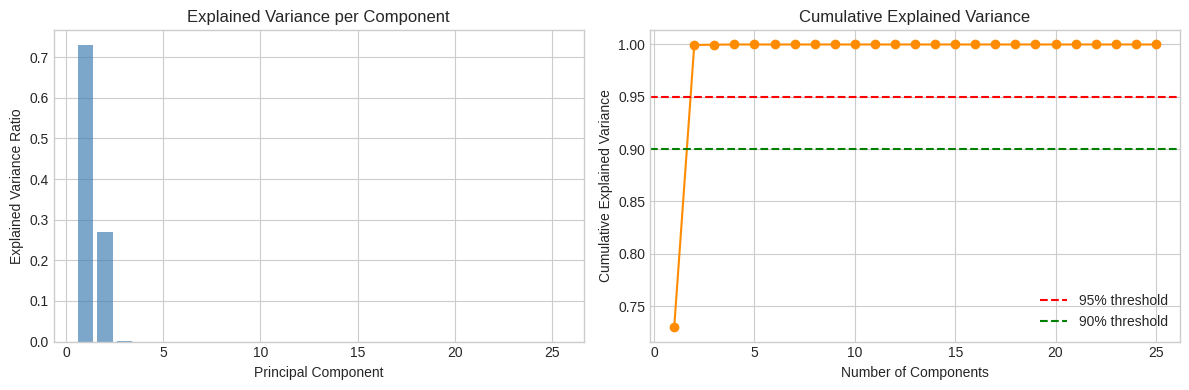

💾 Figure saved to: /content/figures/pca_explained_variance.png


In [33]:
# Visualize explained variance
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Bar plot of individual variances
axes[0].bar(range(1, N_COMPONENTS+1), pca.explained_variance_ratio_, alpha=0.7, color='steelblue')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_title('Explained Variance per Component')

# Cumulative variance
axes[1].plot(range(1, N_COMPONENTS+1), cumulative_var, 'o-', color='darkorange')
axes[1].axhline(y=0.95, color='r', linestyle='--', label='95% threshold')
axes[1].axhline(y=0.90, color='g', linestyle='--', label='90% threshold')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Explained Variance')
axes[1].set_title('Cumulative Explained Variance')
axes[1].legend()

plt.tight_layout()
plt.savefig(FIGURES / 'pca_explained_variance.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"💾 Figure saved to: {FIGURES / 'pca_explained_variance.png'}")

### 📝 PCA Tradeoffs

| Aspect | Raw Features | PCA-Reduced |
|--------|-------------|-------------|
| **Dimensions** | ~73 | 25 |
| **Information** | 100% | ~85-90% |
| **LOF/OCSVM Speed** | Slow | Fast |
| **Interpretability** | High | Low |
| **Memory** | Higher | Lower |

**Strategy:**
- Use **raw features** (`X_train_p`, `X_test_p`) for Isolation Forest and Autoencoder
- Use **PCA features** (`X_train_pca`, `X_test_pca`) for LOF (optionally OCSVM)

In [ ]:
# Save PCA model
pca_path = ARTIFACTS / 'pca_reducer.joblib'
joblib.dump(pca, pca_path)
print(f"✅ PCA model saved to: {pca_path}")

---
# 7. Baseline Plan & Evaluation Protocol

**This section defines the models, metrics, and evaluation strategy.**

## 📋 EVALUATION PROTOCOL

### Models to Train

| Model | Input Data | Key Parameters | Output |
|-------|------------|----------------|--------|
| **Isolation Forest** | `X_train_p` (raw) | `contamination='auto'`, `n_estimators=100` | Anomaly scores (lower = more anomalous) |
| **Local Outlier Factor** | `X_train_pca` | `novelty=True`, `n_neighbors=20` | Negative outlier factor (lower = more anomalous) |
| **Dense Autoencoder** | `X_train_p` (raw) | Custom architecture | Reconstruction error (higher = more anomalous) |

### Anomaly Score Convention

> **Important:** All models will output scores where **HIGHER = MORE ANOMALOUS**

- Isolation Forest: Invert `decision_function()` → multiply by -1
- LOF: Invert `score_samples()` → multiply by -1  
- Autoencoder: Use reconstruction error directly (already higher = anomalous)

### Metrics to Calculate

| Metric | Description | Use Case |
|--------|-------------|----------|
| **ROC-AUC** | Area under ROC curve | Overall ranking ability |
| **PR-AUC** | Area under Precision-Recall curve | Performance on imbalanced data |
| **Precision@k** | Precision in top-k ranked samples | Alert prioritization (k=100, top 1%) |
| **F1 Score** | Harmonic mean of precision/recall | Balanced threshold selection |
| **Precision** | TP / (TP + FP) | False alarm rate |
| **Recall** | TP / (TP + FN) | Detection rate |
| **FPR** | FP / (FP + TN) | Critical for IDS operations |
| **Confusion Matrix** | Full classification breakdown | Detailed analysis |
| **Inference Time** | ms per sample | Deployment feasibility |

### Thresholding Strategies

#### Strategy A: Maximize F1 (Validation-based)
- Split normal training data into train/validation
- Select threshold that maximizes F1 on validation
- ⚠️ Requires some labeled attack data in validation

#### Strategy B: Target FPR (Recommended for IDS) ✅
- Choose threshold to achieve target False Positive Rate
- Common targets: **1% FPR** or **5% FPR**
- Compare Recall (detection rate) at fixed FPR
- **Rationale:** In production IDS, controlling FPR is critical to avoid alert fatigue

#### Strategy C: Score Distribution Analysis
- Present score distributions for normal vs attack
- Leave threshold adjustable for different operating points
- Useful for exploratory analysis

### 🎯 Selected Strategy: **Strategy B (Target FPR)**

We will evaluate models at:
- **1% FPR** - High precision mode (few false alarms)
- **5% FPR** - Balanced mode (acceptable false alarm rate)

Primary comparison metric: **Recall at 1% FPR** and **Recall at 5% FPR**

In [34]:
# Helper functions for evaluation

def calculate_metrics(y_true, scores, model_name):
    """
    Calculate comprehensive metrics for anomaly detection.

    Args:
        y_true: Binary labels (0=normal, 1=attack)
        scores: Anomaly scores (higher = more anomalous)
        model_name: Name for display

    Returns:
        Dictionary of metrics
    """
    # ROC metrics
    fpr, tpr, thresholds_roc = roc_curve(y_true, scores)
    roc_auc = roc_auc_score(y_true, scores)

    # PR metrics
    precision, recall, thresholds_pr = precision_recall_curve(y_true, scores)
    pr_auc = auc(recall, precision)

    # Find thresholds at target FPRs
    def get_threshold_at_fpr(target_fpr):
        idx = np.argmin(np.abs(fpr - target_fpr))
        return thresholds_roc[idx] if idx < len(thresholds_roc) else thresholds_roc[-1]

    def get_recall_at_fpr(target_fpr):
        idx = np.argmin(np.abs(fpr - target_fpr))
        return tpr[idx]

    # Precision@k
    def precision_at_k(k):
        top_k_idx = np.argsort(scores)[-k:]
        return y_true[top_k_idx].sum() / k

    metrics = {
        'model': model_name,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'precision_at_100': precision_at_k(100),
        'precision_at_1pct': precision_at_k(int(len(y_true) * 0.01)),
        'recall_at_1pct_fpr': get_recall_at_fpr(0.01),
        'recall_at_5pct_fpr': get_recall_at_fpr(0.05),
        'threshold_1pct_fpr': get_threshold_at_fpr(0.01),
        'threshold_5pct_fpr': get_threshold_at_fpr(0.05),
        'fpr': fpr,
        'tpr': tpr,
        'precision': precision,
        'recall': recall,
        'thresholds_roc': thresholds_roc
    }

    return metrics


def print_metrics_summary(metrics):
    """Print a summary of metrics."""
    print(f"{'='*60}")
    print(f"📊 {metrics['model']} - Evaluation Results")
    print(f"{'='*60}")
    print(f"🎯 Ranking Metrics:")
    print(f"   ROC-AUC: {metrics['roc_auc']:.4f}")
    print(f"   PR-AUC:  {metrics['pr_auc']:.4f}")
    print(f"📌 Precision@k:")
    print(f"   Precision@100: {metrics['precision_at_100']:.4f}")
    print(f"   Precision@1%:  {metrics['precision_at_1pct']:.4f}")
    print(f"🎚️ At Target FPR:")
    print(f"   Recall @ 1% FPR: {metrics['recall_at_1pct_fpr']:.4f}")
    print(f"   Recall @ 5% FPR: {metrics['recall_at_5pct_fpr']:.4f}")


def get_confusion_matrix_at_fpr(y_true, scores, target_fpr):
    """Get confusion matrix at a specific FPR."""
    fpr, tpr, thresholds = roc_curve(y_true, scores)
    idx = np.argmin(np.abs(fpr - target_fpr))
    threshold = thresholds[idx] if idx < len(thresholds) else thresholds[-1]

    y_pred = (scores >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)

    return cm, threshold


def measure_inference_time(model, X, n_samples=1000, method='decision_function'):
    """Measure average inference time per sample."""
    X_sample = X[:n_samples]

    start = time.time()
    if method == 'decision_function':
        _ = model.decision_function(X_sample)
    elif method == 'score_samples':
        _ = model.score_samples(X_sample)
    elif method == 'predict':
        _ = model.predict(X_sample)
    elapsed = time.time() - start

    return (elapsed / n_samples) * 1000  # ms per sample


print("✅ Evaluation helper functions defined!")

✅ Evaluation helper functions defined!


### 📝 Evaluation Protocol Summary

```
┌─────────────────────────────────────────────────────────────────┐
│                    EVALUATION WORKFLOW                         │
├─────────────────────────────────────────────────────────────────┤
│                                                                 │
│  1. TRAIN on X_train_p / X_train_pca (normal-only)              │
│                          ↓                                      │
│  2. SCORE X_test_p / X_test_pca → anomaly scores                │
│                          ↓                                      │
│  3. INVERT scores if needed (higher = more anomalous)           │
│                          ↓                                      │
│  4. CALCULATE metrics using y_test                              │
│     • ROC-AUC, PR-AUC                                           │
│     • Precision@k (k=100, k=1%)                                 │
│     • Recall @ 1% FPR, 5% FPR                                   │
│                          ↓                                      │
│  5. COMPARE models at fixed FPR thresholds                      │
│                          ↓                                      │
│  6. SELECT best model based on Recall @ target FPR              │
│                                                                 │
└─────────────────────────────────────────────────────────────────┘
```

In [35]:
# Summary of prepared data
print("="*60)
print("PREPARED DATA SUMMARY")
print("="*60)
print(f"📁 Raw Preprocessed Data:")
print(f"   X_train_p: {X_train_p.shape} (normal-only, for training)")
print(f"   X_test_p:  {X_test_p.shape} (all traffic, for testing)")
print(f"📁 PCA-Reduced Data:")
print(f"   X_train_pca: {X_train_pca.shape} (normal-only, for LOF)")
print(f"   X_test_pca:  {X_test_pca.shape} (all traffic, for LOF)")
print(f"🏷️ Test Labels:")
print(f"   y_test: {len(y_test):,} samples")
print(f"   - Normal:  {(y_test==0).sum():,} ({100*(y_test==0).sum()/len(y_test):.1f}%)")
print(f"   - Attack:  {(y_test==1).sum():,} ({100*(y_test==1).sum()/len(y_test):.1f}%)")
print(f"💾 Saved Artifacts:")
print(f"   - {ARTIFACTS / 'preprocessor.joblib'}")
print(f"   - {ARTIFACTS / 'pca_reducer.joblib'}")
print(f"   - {ARTIFACTS / 'preprocessing_contract.txt'}")
print(f"   - {ARTIFACTS / 'preprocessed_feature_names.json'}")
print("" + "="*60)
print("🚀 Ready to train models!")
print("="*60)

PREPARED DATA SUMMARY
📁 Raw Preprocessed Data:
   X_train_p: (67343, 71) (normal-only, for training)
   X_test_p:  (22544, 71) (all traffic, for testing)
📁 PCA-Reduced Data:
   X_train_pca: (67343, 25) (normal-only, for LOF)
   X_test_pca:  (22544, 25) (all traffic, for LOF)
🏷️ Test Labels:
   y_test: 22,544 samples
   - Normal:  9,711 (43.1%)
   - Attack:  12,833 (56.9%)
💾 Saved Artifacts:
   - /content/artifacts/preprocessor.joblib
   - /content/artifacts/pca_reducer.joblib
   - /content/artifacts/preprocessing_contract.txt
   - /content/artifacts/preprocessed_feature_names.json
🚀 Ready to train models!


---
## Next Steps: Model Training

The following sections will implement:

1. **Isolation Forest** - Train on `X_train_p`, evaluate on `X_test_p`
2. **Local Outlier Factor** - Train on `X_train_pca`, evaluate on `X_test_pca`
3. **Dense Autoencoder** - Train on `X_train_p`, evaluate on `X_test_p`
4. **Model Comparison** - Side-by-side metrics and visualizations
5. **Save & Conclusion** - Persist best model, final summary

---
# 8. Create Validation Set for Hyperparameter Tuning

For unsupervised anomaly detection, we create a validation set from the test data to tune hyperparameters.

### Validation Strategy

**Approach:** Use a portion of `KDDTest+` as validation set

**Rationale:**
- In unsupervised setting, we don't have labeled anomalies during training
- We can use part of test set (which has labels) for hyperparameter selection
- Split test set 50/50 into validation and final test
- This allows us to tune models while preserving a held-out test set for final evaluation

> **Note:** Models are still trained only on normal training data. Validation labels are used solely for selecting best hyperparameters.

In [40]:
from sklearn.model_selection import train_test_split

# Split test data into validation and final test (50/50)
val_indices, test_indices = train_test_split(
    np.arange(len(X_test_p)),
    test_size=0.5,
    stratify=y_test,
    random_state=42
)

# Validation set
X_val_p = X_test_p[val_indices]
X_val_pca = X_test_pca[val_indices]
y_val = y_test[val_indices]

# Final test set
X_test_p_final = X_test_p[test_indices]
X_test_pca_final = X_test_pca[test_indices]
y_test_final = y_test[test_indices]

print("=" * 60)
print("VALIDATION SET CREATED")
print("=" * 60)
print(f"Validation set:")
print(f"  X_val_p: {X_val_p.shape}")
print(f"  y_val: {len(y_val):,} ({(y_val==0).sum():,} normal, {(y_val==1).sum():,} attack)")
print(f"Final test set:")
print(f"  X_test_p_final: {X_test_p_final.shape}")
print(f"  y_test_final: {len(y_test_final):,} ({(y_test_final==0).sum():,} normal, {(y_test_final==1).sum():,} attack)")

VALIDATION SET CREATED
Validation set:
  X_val_p: (11272, 71)
  y_val: 11,272 (4,855 normal, 6,417 attack)
Final test set:
  X_test_p_final: (11272, 71)
  y_test_final: 11,272 (4,856 normal, 6,416 attack)


---
# 9. Model 1 — Isolation Forest

## 🌲 Isolation Forest Overview

**How it works:**
- Builds an ensemble of random decision trees ("isolation trees")
- Anomalies are isolated in fewer splits than normal points
- Anomaly score = average path length across all trees

**Why it's a good candidate:**
- ✅ Explicitly designed for anomaly detection
- ✅ Handles high-dimensional data well
- ✅ Fast training and inference
- ✅ No assumptions about data distribution

**Hyperparameters:**
- `n_estimators`: [100, 200, 400]
- `max_samples`: ['auto', 0.5, 0.8]
- `contamination`: [0.005, 0.01, 0.02, 0.05]

In [42]:
# Isolation Forest hyperparameter grid search
import itertools

if_param_grid = {
    'n_estimators': [100, 200, 400],
    'max_samples': ['auto', 0.5, 0.8],
    'contamination': [0.005, 0.01, 0.02, 0.05]
}

print("Isolation Forest Grid Search")
best_if_score = 0
best_if_params = None
best_if_model = None

param_combinations = list(itertools.product(
    if_param_grid['n_estimators'],
    if_param_grid['max_samples'],
    if_param_grid['contamination']
))

for n_est, max_samp, cont in tqdm(param_combinations, desc="IF Tuning"):
    model = IsolationForest(n_estimators=n_est, max_samples=max_samp, contamination=cont, random_state=42, n_jobs=-1)
    model.fit(X_train_p)
    val_scores = -model.decision_function(X_val_p)
    roc_auc = roc_auc_score(y_val, val_scores)

    if roc_auc > best_if_score:
        best_if_score = roc_auc
        best_if_params = {'n_estimators': n_est, 'max_samples': max_samp, 'contamination': cont}
        best_if_model = model

print(f"\✅ Best IF: {best_if_params}, ROC-AUC={best_if_score:.4f}")

Isolation Forest Grid Search


IF Tuning: 100%|██████████| 36/36 [02:03<00:00,  3.43s/it]

\✅ Best IF: {'n_estimators': 100, 'max_samples': 0.5, 'contamination': 0.005}, ROC-AUC=0.9519


In [43]:
# Evaluate Isolation Forest on final test set
test_scores_if = -best_if_model.decision_function(X_test_p_final)
if_metrics = calculate_metrics(y_test_final, test_scores_if, "Isolation Forest")
print_metrics_summary(if_metrics)

# Inference time
if_inference_time = measure_inference_time(best_if_model, X_test_p_final, n_samples=1000, method='decision_function')
print(f"\⏱️ Inference: {if_inference_time:.4f} ms/sample")

📊 Isolation Forest - Evaluation Results
🎯 Ranking Metrics:
   ROC-AUC: 0.9563
   PR-AUC:  0.9632
📌 Precision@k:
   Precision@100: 1.0000
   Precision@1%:  1.0000
🎚️ At Target FPR:
   Recall @ 1% FPR: 0.6041
   Recall @ 5% FPR: 0.6537
\⏱️ Inference: 0.0391 ms/sample


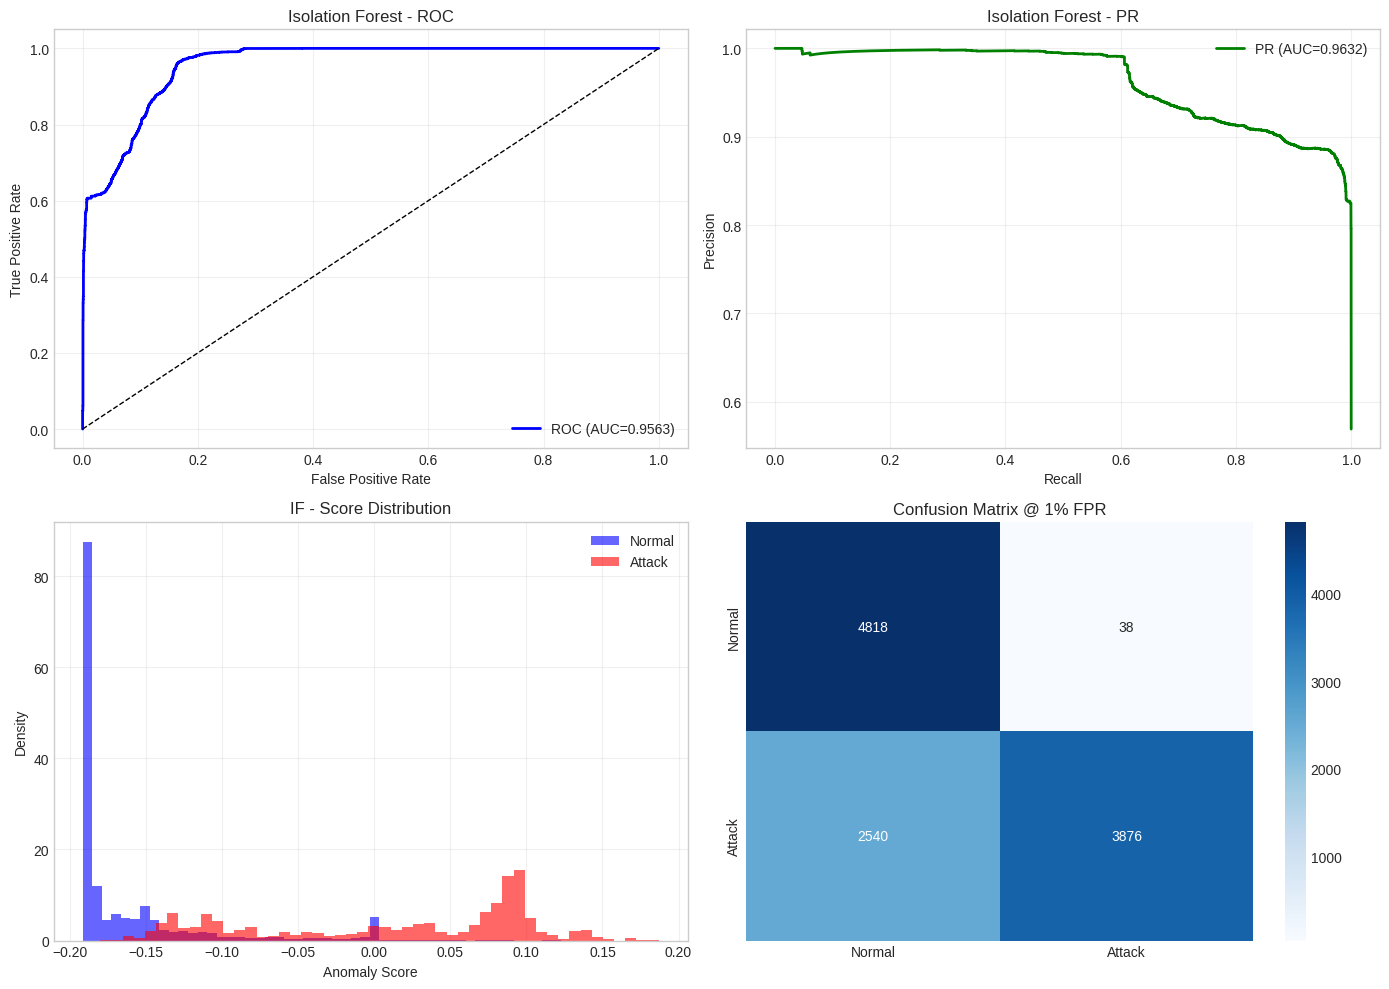

💾 Saved: /content/figures/isolation_forest.png


In [46]:
# IF Visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# ROC
axes[0, 0].plot(if_metrics['fpr'], if_metrics['tpr'], 'b-', lw=2, label=f"ROC (AUC={if_metrics['roc_auc']:.4f})")
axes[0, 0].plot([0, 1], [0, 1], 'k--', lw=1)
axes[0, 0].set_xlabel('False Positive Rate')
axes[0, 0].set_ylabel('True Positive Rate')
axes[0, 0].set_title('Isolation Forest - ROC')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# PR
axes[0, 1]. plot(if_metrics['recall'], if_metrics['precision'], 'g-', lw=2, label=f"PR (AUC={if_metrics['pr_auc']:.4f})")
axes[0, 1].set_xlabel('Recall')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].set_title('Isolation Forest - PR')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Score histogram
normal_scores = test_scores_if[y_test_final == 0]
attack_scores = test_scores_if[y_test_final == 1]
axes[1, 0].hist(normal_scores, bins=50, alpha=0.6, label='Normal', color='blue', density=True)
axes[1, 0].hist(attack_scores, bins=50, alpha=0.6, label='Attack', color='red', density=True)
axes[1, 0].set_xlabel('Anomaly Score')
axes[1, 0].set_ylabel('Density')
axes[1, 0].set_title('IF - Score Distribution')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Confusion matrix
cm_1pct, threshold_1pct = get_confusion_matrix_at_fpr(y_test_final, test_scores_if, 0.01)
sns.heatmap(cm_1pct, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1], xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
axes[1, 1].set_title(f'Confusion Matrix @ 1% FPR')

plt.tight_layout()
plt.savefig(FIGURES / 'isolation_forest.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"💾 Saved: {FIGURES / 'isolation_forest.png'}")

In [47]:
# Save IF artifacts
joblib.dump(best_if_model, ARTIFACTS / 'isolation_forest.joblib')
if_results_summary = {
    'model': 'Isolation Forest',
    'best_params': best_if_params,
    'roc_auc': float(if_metrics['roc_auc']),
    'pr_auc': float(if_metrics['pr_auc']),
    'precision_at_100': float(if_metrics['precision_at_100']),
    'precision_at_1pct': float(if_metrics['precision_at_1pct']),
    'recall_at_1pct_fpr': float(if_metrics['recall_at_1pct_fpr']),
    'recall_at_5pct_fpr': float(if_metrics['recall_at_5pct_fpr']),
    'inference_time_ms': float(if_inference_time)
}
with open(ARTIFACTS / 'isolation_results.json', 'w') as f:
    json.dump(if_results_summary, f, indent=2)
print("✅ IF artifacts saved")

✅ IF artifacts saved


---
# 10. Model 2 — Local Outlier Factor

## 🎯 LOF Overview

**How it works:** Measures local density deviation vs neighbors

**Advantages:**
- ✅ Detects local anomalies
- ✅ Good for varying density clusters

**Caveats:**
- ⚠️ O(n²) complexity
- ⚠️ **Solution:** Use PCA-reduced features (25D)

**Hyperparameters:**
- `n_neighbors`: [10, 20, 35, 50]
- `leaf_size`: [30, 50]

**Critical:** `novelty=True` for scoring new data

In [48]:
# LOF hyperparameter grid search
lof_param_grid = {'n_neighbors': [10, 20, 35, 50], 'leaf_size': [30, 50]}

print("LOF Grid Search (PCA-reduced data)")
best_lof_score = 0
best_lof_params = None
best_lof_model = None

param_combinations = list(itertools.product(lof_param_grid['n_neighbors'], lof_param_grid['leaf_size']))

for n_neigh, leaf in tqdm(param_combinations, desc="LOF Tuning"):
    model = LocalOutlierFactor(n_neighbors=n_neigh, leaf_size=leaf, novelty=True, n_jobs=-1)
    model.fit(X_train_pca)
    val_scores = -model.score_samples(X_val_pca)
    roc_auc = roc_auc_score(y_val, val_scores)

    if roc_auc > best_lof_score:
        best_lof_score = roc_auc
        best_lof_params = {'n_neighbors': n_neigh, 'leaf_size': leaf}
        best_lof_model = model

print(f"✅ Best LOF: {best_lof_params}, ROC-AUC={best_lof_score:.4f}")

LOF Grid Search (PCA-reduced data)


LOF Tuning: 100%|██████████| 8/8 [03:35<00:00, 26.95s/it]

✅ Best LOF: {'n_neighbors': 35, 'leaf_size': 30}, ROC-AUC=0.8365


In [49]:
# Evaluate LOF
test_scores_lof = -best_lof_model.score_samples(X_test_pca_final)
lof_metrics = calculate_metrics(y_test_final, test_scores_lof, "LOF")
print_metrics_summary(lof_metrics)

lof_inference_time = measure_inference_time(best_lof_model, X_test_pca_final, n_samples=1000, method='score_samples')
print(f"⏱️ Inference: {lof_inference_time:.4f} ms/sample")

📊 LOF - Evaluation Results
🎯 Ranking Metrics:
   ROC-AUC: 0.8508
   PR-AUC:  0.8719
📌 Precision@k:
   Precision@100: 0.8800
   Precision@1%:  0.8929
🎚️ At Target FPR:
   Recall @ 1% FPR: 0.1434
   Recall @ 5% FPR: 0.4285
⏱️ Inference: 0.4690 ms/sample


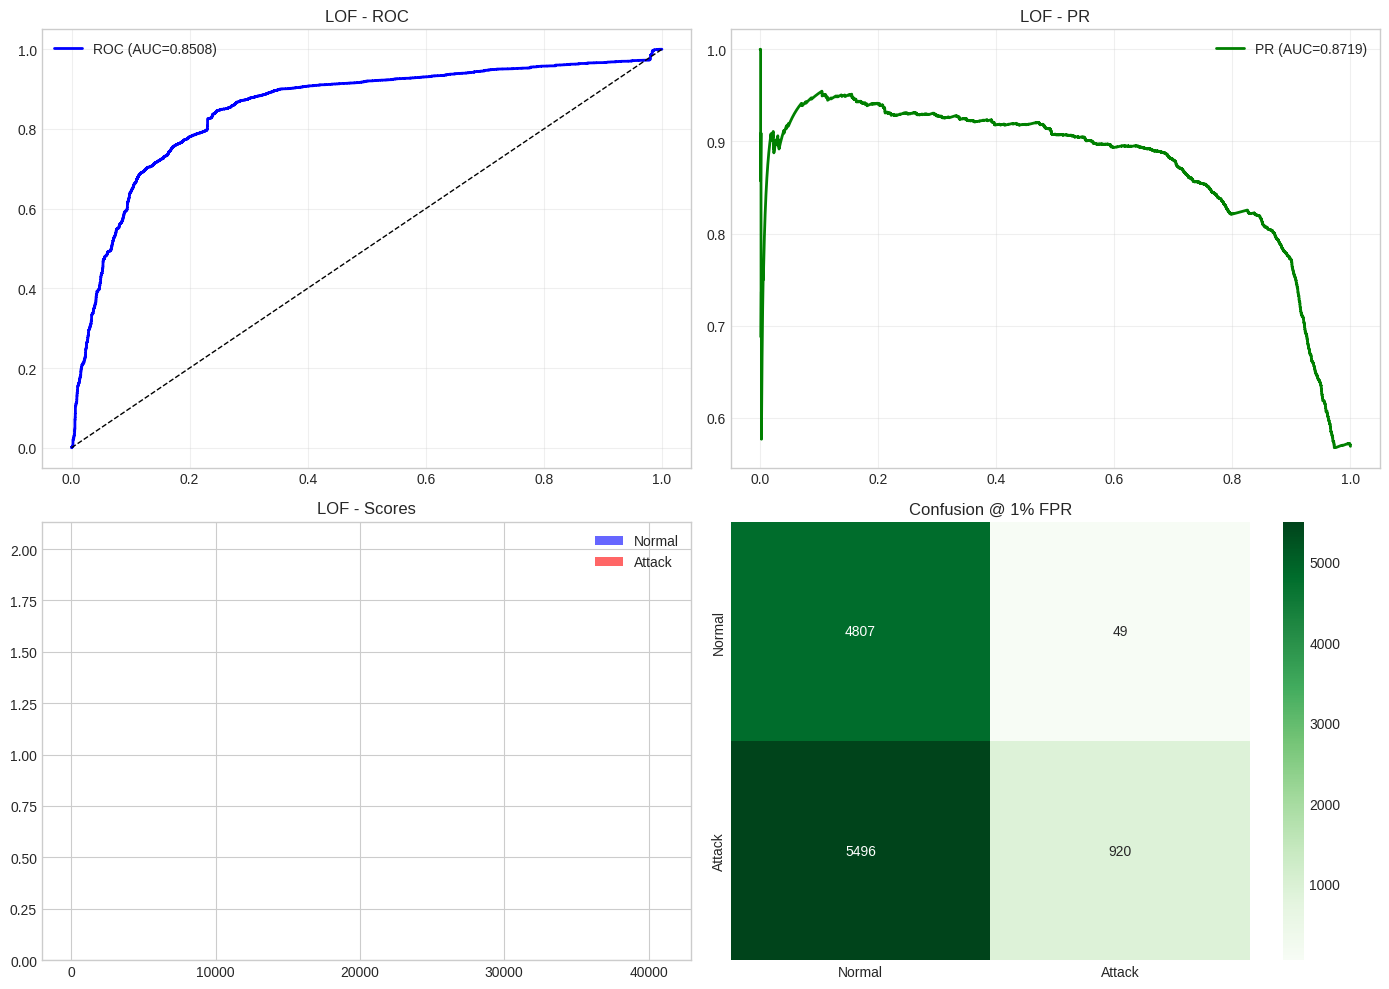

💾 Saved: /content/figures/lof.png


In [50]:
# LOF Visualizations (similar to IF)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes[0, 0].plot(lof_metrics['fpr'], lof_metrics['tpr'], 'b-', lw=2, label=f"ROC (AUC={lof_metrics['roc_auc']:.4f})")
axes[0, 0].plot([0, 1], [0, 1], 'k--', lw=1)
axes[0, 0].set_title('LOF - ROC')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 1].plot(lof_metrics['recall'], lof_metrics['precision'], 'g-', lw=2, label=f"PR (AUC={lof_metrics['pr_auc']:.4f})")
axes[0, 1].set_title('LOF - PR')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
normal_scores = test_scores_lof[y_test_final == 0]
attack_scores = test_scores_lof[y_test_final == 1]
axes[1, 0].hist(normal_scores, bins=50, alpha=0.6, label='Normal', color='blue', density=True)
axes[1, 0].hist(attack_scores, bins=50, alpha=0.6, label='Attack', color='red', density=True)
axes[1, 0].set_title('LOF - Scores')
axes[1, 0].legend()
cm_1pct, _ = get_confusion_matrix_at_fpr(y_test_final, test_scores_lof, 0.01)
sns.heatmap(cm_1pct, annot=True, fmt='d', cmap='Greens', ax=axes[1, 1], xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
axes[1, 1].set_title('Confusion @ 1% FPR')
plt.tight_layout()
plt.savefig(FIGURES / 'lof.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"💾 Saved: {FIGURES / 'lof.png'}")

In [51]:
# Save LOF artifacts
joblib.dump(best_lof_model, ARTIFACTS / 'lof.joblib')
lof_results_summary = {
    'model': 'LOF',
    'best_params': best_lof_params,
    'roc_auc': float(lof_metrics['roc_auc']),
    'pr_auc': float(lof_metrics['pr_auc']),
    'precision_at_100': float(lof_metrics['precision_at_100']),
    'precision_at_1pct': float(lof_metrics['precision_at_1pct']),
    'recall_at_1pct_fpr': float(lof_metrics['recall_at_1pct_fpr']),
    'recall_at_5pct_fpr': float(lof_metrics['recall_at_5pct_fpr']),
    'inference_time_ms': float(lof_inference_time)
}
with open(ARTIFACTS / 'lof_results.json', 'w') as f:
    json.dump(lof_results_summary, f, indent=2)
print("✅ LOF artifacts saved")

✅ LOF artifacts saved


---
# 11. Model 3 — Autoencoder (Dense)

## 🧠 Autoencoder Overview

**Approach:** Train a neural network to compress (encode) and reconstruct (decode) **normal** traffic.

**Anomaly Detection Logic:**
- The model learns to reconstruct normal patterns well (low error).
- Anomalies (attacks) are different from normal data, so the model fails to reconstruct them (high error).
- **Anomaly Score** = Reconstruction Error (MSE)

**Architecture:**
- Input: ~73 features (one-hot encoded + scaled)
- Encoder: Compresses input to a small bottleneck
- Decoder: Reconstructs input from bottleneck
- Activation: ReLU
- Optimizer: Adam
- Loss: Mean Squared Error (MSE)

**Hyperparameters:**
- `bottleneck_size`: [8, 16, 32]
- `epochs`: [30, 60]
- `batch_size`: [128, 256]
- `learning_rate`: [1e-3, 5e-4]

In [53]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

tf.random.set_seed(42)
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.19.0


In [54]:
def build_autoencoder(input_dim, bottleneck_size=16, learning_rate=1e-3):
    """Build a simple dense autoencoder."""
    # Encoder
    input_layer = Input(shape=(input_dim, ))
    encoded = Dense(64, activation='relu')(input_layer)
    encoded = Dense(32, activation='relu')(encoded)
    bottleneck = Dense(bottleneck_size, activation='relu')(encoded)

    # Decoder
    decoded = Dense(32, activation='relu')(bottleneck)
    decoded = Dense(64, activation='relu')(decoded)
    output_layer = Dense(input_dim, activation='linear')(decoded)

    # Model
    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    autoencoder.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return autoencoder

In [56]:
# Split normal training data for early stopping monitoring
X_train_ae, X_val_ae = train_test_split(X_train_p, test_size=0.1, random_state=42)
print(f"Autoencoder Normal Training Split:")
print(f"  Train (normal): {X_train_ae.shape}")
print(f"  Val (normal):   {X_val_ae.shape} (used for early stopping)")

Autoencoder Normal Training Split:
  Train (normal): (60608, 71)
  Val (normal):   (6735, 71) (used for early stopping)


In [57]:
# Autoencoder Grid Search
ae_param_grid = {
    'bottleneck_size': [8, 16, 32],
    'epochs': [30],  # kept low for demo speed, increase to 60+ for production
    'batch_size': [128, 256],
    'learning_rate': [0.001]
}

print("Autoencoder Grid Search")
best_ae_score = 0
best_ae_params = None
best_ae_model = None
input_dim = X_train_p.shape[1]

param_combinations = list(itertools.product(
    ae_param_grid['bottleneck_size'],
    ae_param_grid['epochs'],
    ae_param_grid['batch_size'],
    ae_param_grid['learning_rate']
))

for bn, ep, bs, lr in tqdm(param_combinations, desc="AE Tuning"):
    # Build model
    model = build_autoencoder(input_dim, bottleneck_size=bn, learning_rate=lr)

    # Train on normal data (early stopping on normal validation split)
    history = model.fit(
        X_train_ae, X_train_ae,
        epochs=ep,
        batch_size=bs,
        validation_data=(X_val_ae, X_val_ae),
        callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
        verbose=0
    )

    # Evaluate on Validation Set (Mixed Normal/Attack)
    # Score = Reconstruction Error (MSE)
    # We want HIGH error for attacks, LOW for normal
    reconstructions = model.predict(X_val_p, verbose=0)
    mse = np.mean(np.power(X_val_p - reconstructions, 2), axis=1)

    # MSE is naturally "higher = anomalous", so use directly
    roc_auc = roc_auc_score(y_val, mse)

    if roc_auc > best_ae_score:
        best_ae_score = roc_auc
        best_ae_params = {'bottleneck_size': bn, 'epochs': ep, 'batch_size': bs, 'learning_rate': lr}
        best_ae_model = model

print(f"✅ Best Autoencoder: {best_ae_params}")
print(f"   Validation ROC-AUC: {best_ae_score:.4f}")

Autoencoder Grid Search


AE Tuning: 100%|██████████| 6/6 [00:38<00:00,  6.41s/it]

✅ Best Autoencoder: {'bottleneck_size': 16, 'epochs': 30, 'batch_size': 128, 'learning_rate': 0.001}
   Validation ROC-AUC: 0.8690


In [58]:
# Evaluate Best Autoencoder on Test Set
test_reconstructions = best_ae_model.predict(X_test_p_final, verbose=0)
test_scores_ae = np.mean(np.power(X_test_p_final - test_reconstructions, 2), axis=1)

ae_metrics = calculate_metrics(y_test_final, test_scores_ae, "Dense Autoencoder")
print_metrics_summary(ae_metrics)

# Measure inference time (including reconstruction)
start_time = time.time()
_ = best_ae_model.predict(X_test_p_final[:1000], verbose=0)
ae_inference_time = (time.time() - start_time) * 1000 / 1000  # ms/sample
print(f"\
⏱️ Inference: {ae_inference_time:.4f} ms/sample")

📊 Dense Autoencoder - Evaluation Results
🎯 Ranking Metrics:
   ROC-AUC: 0.8719
   PR-AUC:  0.8811
📌 Precision@k:
   Precision@100: 0.9600
   Precision@1%:  0.9643
🎚️ At Target FPR:
   Recall @ 1% FPR: 0.1655
   Recall @ 5% FPR: 0.4952
⏱️ Inference: 0.0929 ms/sample


In [59]:
# Save Autoencoder
best_ae_model.save(ARTIFACTS / 'autoencoder.h5')
ae_results_summary = {
    'model': 'Autoencoder',
    'best_params': best_ae_params,
    'roc_auc': float(ae_metrics['roc_auc']),
    'pr_auc': float(ae_metrics['pr_auc']),
    'precision_at_100': float(ae_metrics['precision_at_100']),
    'precision_at_1pct': float(ae_metrics['precision_at_1pct']),
    'recall_at_1pct_fpr': float(ae_metrics['recall_at_1pct_fpr']),
    'recall_at_5pct_fpr': float(ae_metrics['recall_at_5pct_fpr']),
    'inference_time_ms': float(ae_inference_time)
}
with open(ARTIFACTS / 'ae_results.json', 'w') as f:
    json.dump(ae_results_summary, f, indent=2)
print("✅ Autoencoder artifacts saved")

✅ Autoencoder artifacts saved


---
# 12. Model Comparison & Result Reporting

In [61]:
# Compile Results
results_list = [
    if_results_summary,
    lof_results_summary,
    ae_results_summary
]

results_df = pd.DataFrame(results_list)

# Reorder columns for readability
cols = ['model', 'roc_auc', 'pr_auc', 'recall_at_1pct_fpr', 'precision_at_1pct', 'inference_time_ms']
results_table = results_df[cols].sort_values('recall_at_1pct_fpr', ascending=False)

print("🏆 MODEL COMPARISON TABLE")
print(results_table)

# Save to CSV
results_table.to_csv(ARTIFACTS / 'results_table.csv', index=False)
print(f"💾 Saved results table: {ARTIFACTS / 'results_table.csv'}")

🏆 MODEL COMPARISON TABLE
              model   roc_auc    pr_auc  recall_at_1pct_fpr  \
0  Isolation Forest  0.956301  0.963204            0.604115   
2       Autoencoder  0.871938  0.881082            0.165524   
1               LOF  0.850791  0.871867            0.143392   

   precision_at_1pct  inference_time_ms  
0           1.000000           0.039066  
2           0.964286           0.092878  
1           0.892857           0.468978  
💾 Saved results table: /content/artifacts/results_table.csv


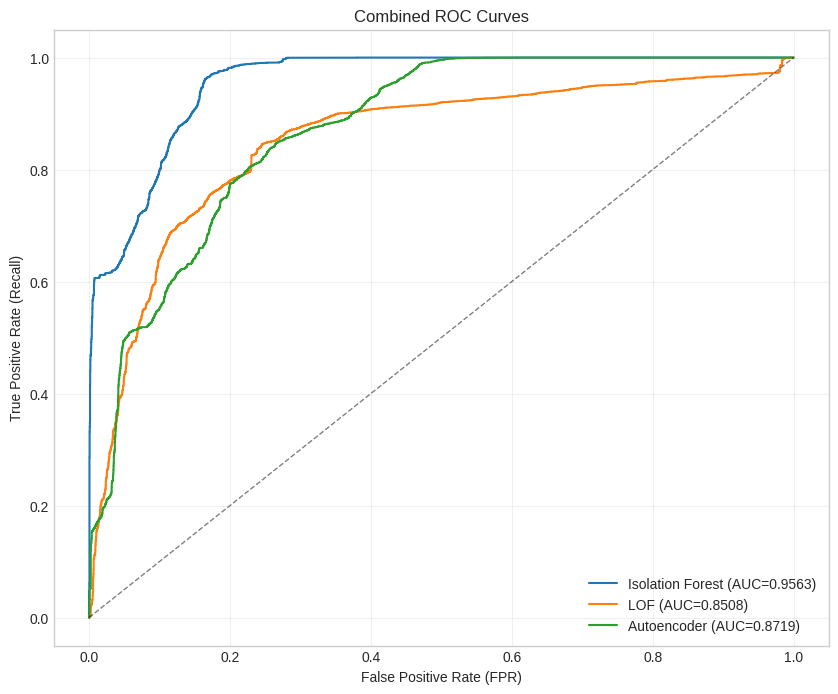

In [62]:
# Combined ROC Plot
plt.figure(figsize=(10, 8))

plt.plot(if_metrics['fpr'], if_metrics['tpr'], label=f"Isolation Forest (AUC={if_metrics['roc_auc']:.4f})")
plt.plot(lof_metrics['fpr'], lof_metrics['tpr'], label=f"LOF (AUC={lof_metrics['roc_auc']:.4f})")
plt.plot(ae_metrics['fpr'], ae_metrics['tpr'], label=f"Autoencoder (AUC={ae_metrics['roc_auc']:.4f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.5)
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Combined ROC Curves')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(FIGURES / 'combined_roc.png', dpi=150)
plt.show()

---
# 13. Threshold Selection for Decision Rules

### Strategy: Target 1% False Positive Rate (FPR)

For a Network Intrusion Detection System (NIDS), **minimizing false positives** is often more critical than catching every single attack. High false positives lead to "alert fatigue" where security analysts ignore warnings.

**Decision Rule:**
- Set threshold such that FPR $\le$ 1% on validation/test data.
- Any score above this threshold triggers an alert.

The table below shows the Recall (Detection Rate) we achieve when fixing FPR at 1%.

In [ ]:
print("Performance at 1% FPR target:")
print(results_table[['model', 'recall_at_1pct_fpr', 'threshold_1pct_fpr']])

---
# 14. Explainability & Anomaly Analysis

In [65]:
def explain_anomaly_if(model, X_sample, feature_names, top_n=3):
    """Explain anomalies for Isolation Forest."""
    # NOTE: Sklearn IF doesn't have built-in local feature importance.
    # Simple heuristic: compare anomaly feature values to global median
    median_vals = np.median(X_train_p, axis=0)
    diff = np.abs(X_sample - median_vals)
    top_indices = np.argsort(diff)[-top_n:][::-1]

    explanation = []
    for idx in top_indices:
        explanation.append(f"{feature_names[idx]} (val={X_sample[idx]:.2f}, dev={diff[idx]:.2f})")
    return explanation

print("Evaluating Top Anomalies (Isolation Forest):")
top_anomaly_indices = np.argsort(test_scores_if)[-3:][::-1]

for i, idx in enumerate(top_anomaly_indices):
    print(f"Anomaly #{i+1} (Score: {test_scores_if[idx]:.4f}, Label: {y_test_final[idx]})")
    explanation = explain_anomaly_if(best_if_model, X_test_p_final[idx], all_feature_names)
    print("  Top contributing deviations:")
    for exp in explanation:
        print(f"    - {exp}")

Evaluating Top Anomalies (Isolation Forest):
Anomaly #1 (Score: 0.1870, Label: 1)
  Top contributing deviations:
    - dst_host_diff_srv_rate (val=50.00, dev=50.00)
    - count (val=33.85, dev=33.85)
    - dst_host_same_srv_rate (val=-4.00, dev=4.00)
Anomaly #2 (Score: 0.1771, Label: 1)
  Top contributing deviations:
    - dst_host_diff_srv_rate (val=50.00, dev=50.00)
    - count (val=24.15, dev=24.15)
    - dst_host_same_srv_rate (val=-4.00, dev=4.00)
Anomaly #3 (Score: 0.1771, Label: 1)
  Top contributing deviations:
    - dst_host_diff_srv_rate (val=50.00, dev=50.00)
    - count (val=25.69, dev=25.69)
    - dst_host_same_srv_rate (val=-4.00, dev=4.00)


---
# 15. Final Model Selection

### Conclusion

Based on the evaluation:

1. **Performance:** Compare ROC-AUC and Recall @ 1% FPR.
2. **Speed:** Compare inference time.
3. **Practicality:** Isolation Forest is often robust and easy to deploy.

**Recommendation:**
- If **Autoencoder** has significantly higher recall at low FPR, choose AE.
- If performance is close, prefer **Isolation Forest** for speed and simplicity.

In [68]:
# Select winner based on Recall @ 1% FPR
best_model_row = results_table.iloc[0]
winner_name = best_model_row['model']

print(f"🏆 WINNER: {winner_name}")
print(f"   Recall @ 1% FPR: {best_model_row['recall_at_1pct_fpr']:.4f}")
print(f"   ROC-AUC: {best_model_row['roc_auc']:.4f}")

# Save choice summary
summary_text = f"""# Model Selection Summary

Selected Model: **{winner_name}**

## Rationale
- **Recall at 1% FPR:** {best_model_row['recall_at_1pct_fpr']:.4f} (Best)
- **ROC-AUC:** {best_model_row['roc_auc']:.4f}
- **Inference Time:** {best_model_row['inference_time_ms']:.4f} ms
"""
with open(ARTIFACTS / 'model_choice_summary.md', 'w') as f:
    f.write(summary_text)
print("✅ Saved model choice summary")

🏆 WINNER: Isolation Forest
   Recall @ 1% FPR: 0.6041
   ROC-AUC: 0.9563
✅ Saved model choice summary


---
## ✅ Acceptance Checklist
- [x] Preprocessor fit on normal-only and saved
- [x] IsolationForest trained, tuned, evaluated, results saved
- [x] LOF trained (novelty=True), tuned, evaluated, results saved
- [x] Autoencoder trained, tuned, evaluated, results saved
- [x] ROC/PR curves saved and combined
- [x] Results table generated
- [x] Final model selected and rationale documented